In [5]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [6]:
# module level imports
import sys
sys.path.append("..")

from src.distributions import log_gaussian
from src.utils import logsumexp

In [7]:
def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

In [8]:
# generate some clusters
cluster1 = sample(
    torch.Tensor([2.5, 2.5]),
    torch.Tensor([1.2, .8]),
    nb_samples=500
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5]),
    nb_samples=500
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8]),
    nb_samples=1000
)

In [9]:
def plot_2d_sample(sample):
    sample_np = sample.numpy()
    x = sample_np[:, 0]
    y = sample_np[:, 1]
    plt.scatter(x, y)

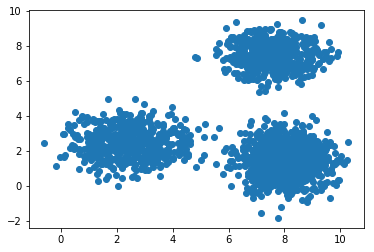

In [10]:
# create the dummy dataset, by combining the clusters.
X = torch.cat([cluster1, cluster2, cluster3])
plot_2d_sample(X)

In [11]:
def initialize(data, k, var=1):
    """
    Randomly initialize the parameters for `k` gaussians.
    :param data: design matrix (examples, features)
    :param k: number of gaussians
    :param var: initial variance
    """
    # choose k points from data to initialize means
    m = data.size(0)
    idxs = torch.from_numpy(np.random.choice(m, k, replace=False))
    mu = data[idxs]

    # uniform sampling for means and variances
    var = torch.Tensor(k, d).fill_(var)
    
    # uniform prior
    pi = torch.empty(k).fill_(1. / k)

    return mu, var, pi

In [12]:
def get_likelihoods(X, mu, logvar, log=True):
    """
    Compute the likelihood of each data point under each gaussians.
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?
        Note: exponentiating can be unstable in high dimensions.
    :return likelihoods: (K, examples)
    """
    
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        mu[:, None, :], # (K, 1, features)
        logvar[:, None, :] # (K, 1, features)
    )
    
    # sum over the feature dimension
    log_likelihoods = log_likelihoods.sum(-1)
    
    if not log:
        log_likelihoods.exp_()

    return log_likelihoods

In [13]:
def get_posteriors(log_likelihoods, log_pi):
    """
    Calculate the the posterior probabities log p(z|x), assuming a uniform prior over
    components (for this step only).
    :param likelihoods: the relative likelihood p(x|z), of each data point under each mode (K, examples)
    :param log_pi: log prior (K)
    :return: the log posterior p(z|x) (K, examples)
    """
    posteriors = log_likelihoods # + log_pi[:, None]
    posteriors = posteriors - logsumexp(posteriors, dim=0, keepdim=True)
    return posteriors

In [18]:
def get_parameters(X, log_posteriors, eps=1e-6, min_var=1e-6):
    """
    :param X: design matrix (examples, features)
    :param log_posteriors: the log posterior probabilities p(z|x) (K, examples)
    :returns mu, var, pi: (K, features) , (K, features) , (K)
    """
    
    posteriors = log_posteriors.exp()

    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = posteriors.size(0)
    N_k = torch.sum(posteriors, dim=1) # (K)
    N_k = N_k.view(K, 1, 1)

    # get the means by taking the weighted combination of points
    # (K, 1, examples) @ (1, examples, features) -> (K, 1, features)
    mu = posteriors[:, None] @ X[None,]
    mu = mu / (N_k + eps)

    # compute the diagonal covar. matrix, by taking a weighted combination of
    # the each point's square distance from the mean
    A = X.unsqueeze(0) - mu
    print("A {}, X {}, mu {}".format(A.size(), X.size(), mu.size()))
    var = posteriors[:, None] @ (A ** 2) # (K, 1, features)
    var = var / (N_k + eps)
    logvar = torch.clamp(var, min=min_var).log()

    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples
    pi = N_k / N_k.sum()

    return mu.squeeze(1), logvar.squeeze(1), pi.squeeze()

In [19]:
def get_density(mu, logvar, pi, N=50, X_range=(0, 5), Y_range=(0, 5)):
    """ Get the mesh to compute the density on. """
    X = np.linspace(*X_range, N)
    Y = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    points = torch.from_numpy(points).float()
    
    # compute the densities under each mixture
    P = get_likelihoods(points, mu, logvar, log=False)
    
    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).data.numpy().reshape([N, N])
    
    return X, Y, Z

In [20]:
def plot_density(X, Y, Z, i=0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.inferno)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
#     plt.savefig('fig_{}.png'.format(i), dpi=400, bbox_inches='tight')
    plt.show()

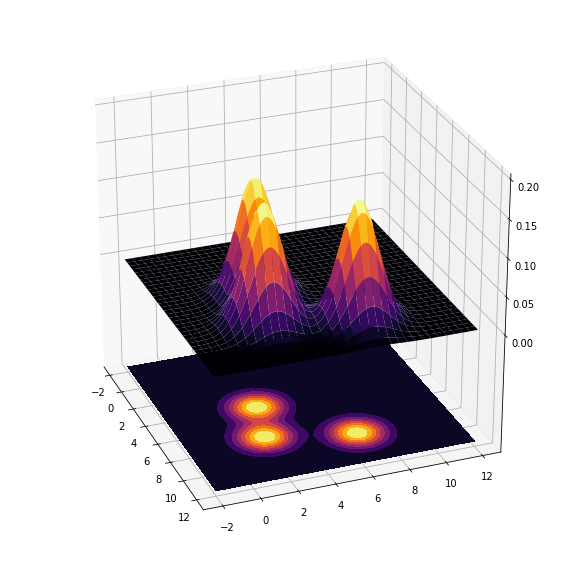

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


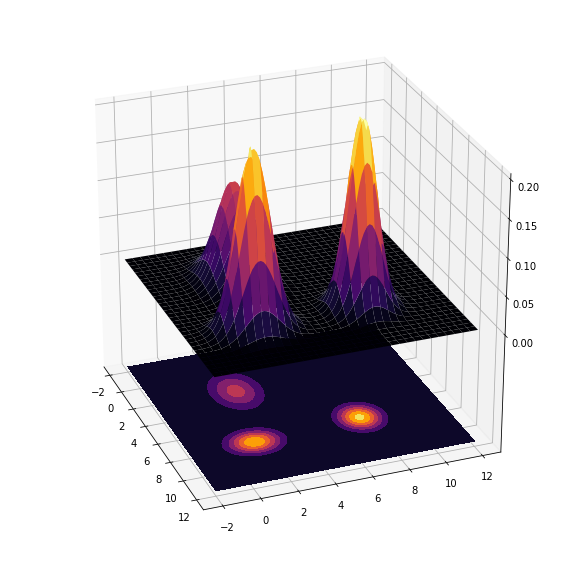

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


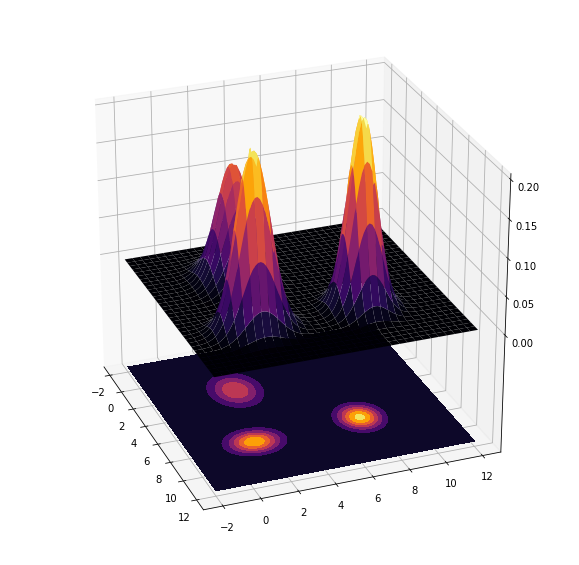

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


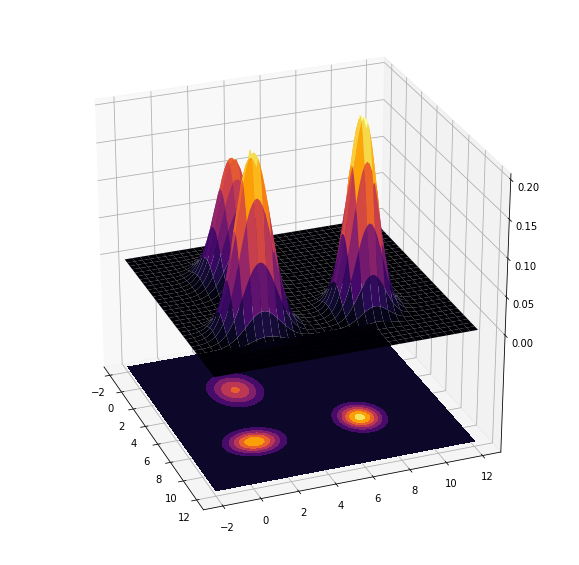

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


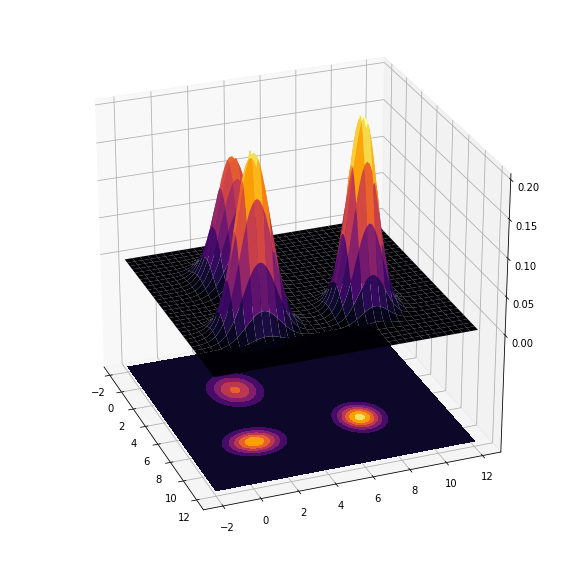

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


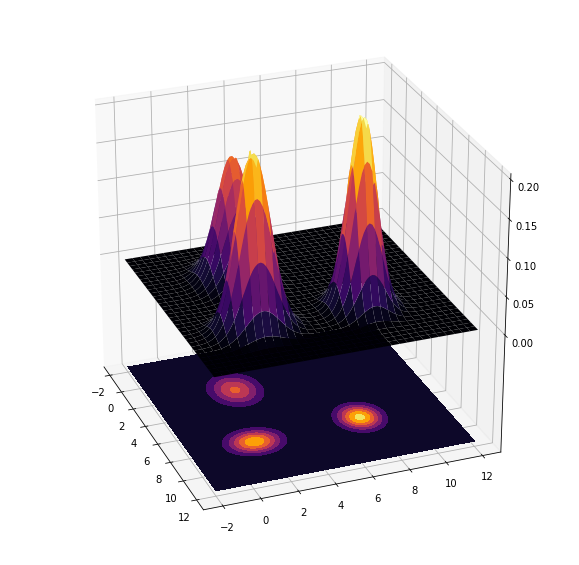

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


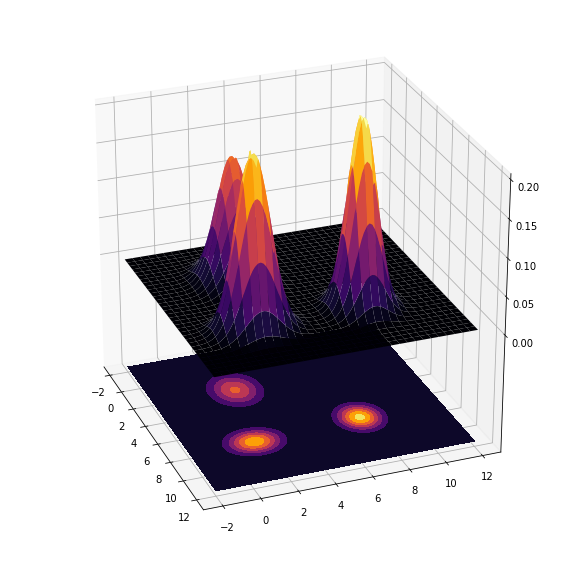

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


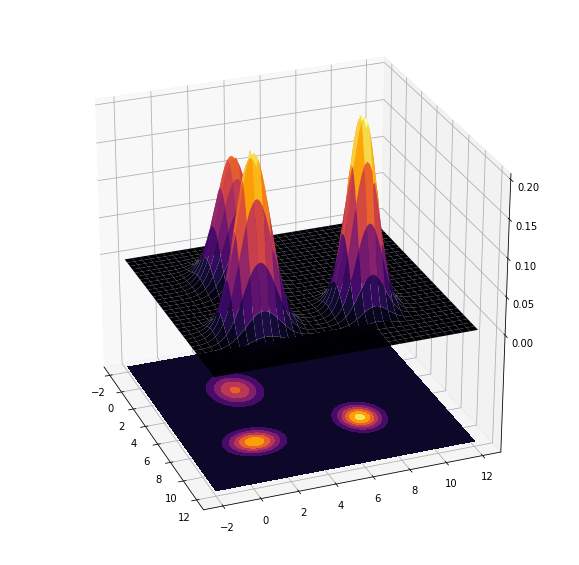

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


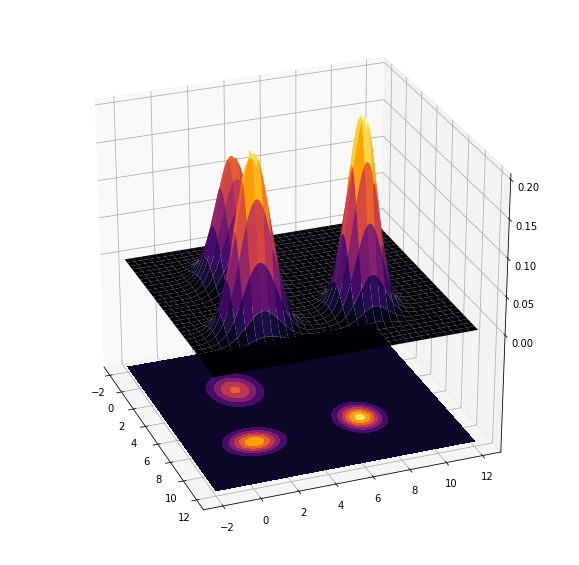

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


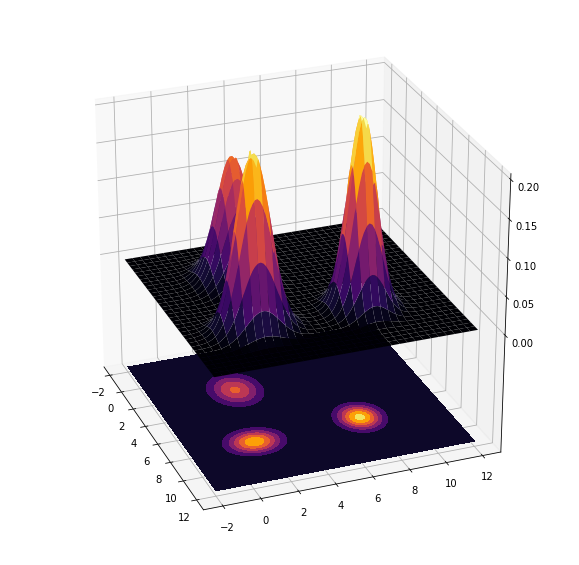

A torch.Size([3, 2000, 2]), X torch.Size([2000, 2]), mu torch.Size([3, 1, 2])


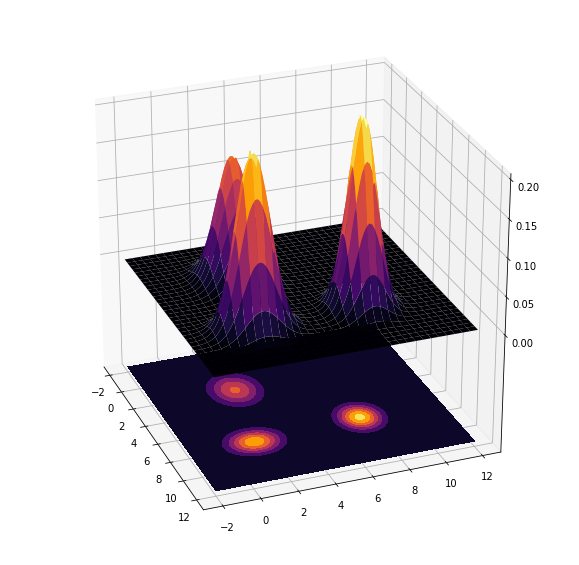

In [21]:
# training loop
k = 3
d = 2
nb_iters = 50

data = X
mu, var, pi = initialize(data, k, var=1)
logvar = var.log()

prev_cost = float('inf')
thresh = 1e-5
for i in tqdm(range(nb_iters)):
    # get the likelihoods p(x|z) under the parameters
    log_likelihoods = get_likelihoods(data, mu, logvar)
    
    # plot!
    plot_density(*get_density(mu, logvar, pi, N=100, X_range=(-2, 12), Y_range=(-2, 12)), i=i)
    
    # compute the "responsibilities" p(z|x)
    log_posteriors = get_posteriors(log_likelihoods, pi.log())
    
    # compute the cost and check for convergence
    cost = log_likelihoods.mean()
    diff = prev_cost - cost
    if torch.abs(diff).item() < thresh:
        break
    prev_cost = cost
    
    # re-compute parameters
    mu, logvar, pi = get_parameters(data, log_posteriors)

In [58]:
print(mu)
print(logvar.exp())
print(pi)

tensor([[6.1910, 1.8116],
        [7.3612, 7.6349],
        [7.6937, 7.5090]])
tensor([[7.3211, 1.0206],
        [0.8479, 0.4095],
        [0.4873, 0.3878]])
tensor([0.7501, 0.1253, 0.1247])


In [15]:
# # EXAMPLE PLOT
# x = np.arange(0, 10, 0.1)
# y1 = multivariate_normal.pdf(x, mean=2, cov=1.2)
# y2 = multivariate_normal.pdf(x, mean=4.8, cov=0.8)
# sns.set_style("darkgrid")
# plt.figure(figsize=(8, 8))
# plt.plot(x, y1/2, linewidth=2)
# plt.plot(x, y2/2, linewidth=2)
# plt.plot(x, (y1+y2)/2, linewidth=2, ls="--")
# # plt.ylabel('f(x)', fontsize=14)
# # plt.xlabel('x', fontsize=14)
# plt.title("Mixture of 1D Gaussians", fontsize=16)
# plt.legend(['Component 1', 'Component 2', 'Mixture'])
# plt.savefig('mixture.png', dpi=400)
# plt.show()
# # print(a.size())